<a href="https://colab.research.google.com/github/jserrataylor/cursoAI/blob/main/Modelo_Identificacion_Matriculas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract

In [ ]:
!pip install opencv-python
!pip install numpy
!pip install pytesseract

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
#import LPR

In [14]:
class LPR:
    def grayscale(self, img):
        # Convertir la imagen a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return gray

    def apply_threshold(self, img):
        # Aplicar umbral adaptativo
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh

    def find_contours(self, img):
        # Encontrar contornos en la imagen
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contours

    # Resto de métodos de la clase LPR
    # ...


In [75]:
def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# idx = 7
# lpr = LPR.LPR()

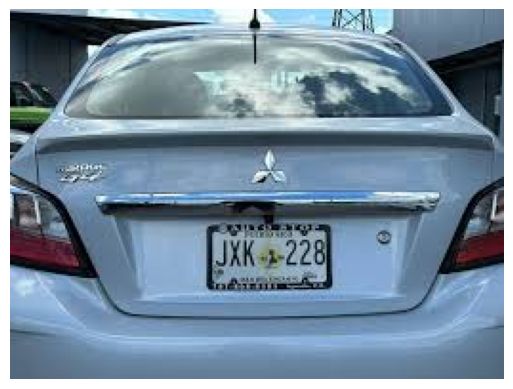

In [80]:
#img = cv2.imread(f"/content/drive/MyDrive/Colab Notebooks/Proyecto_Matrica_Automovil/imgs/{i:03}.png")
img = cv2.imread(f"/content/drive/MyDrive/Colab Notebooks/Proyecto_Matrica_Automovil/imgs-2/{i:03}.jpeg")
plot_image(img, False)

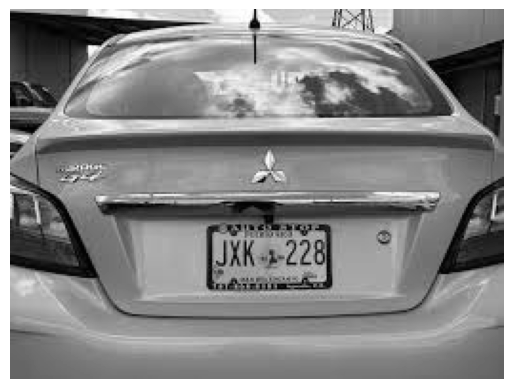

In [77]:
gray = lpr.grayscale(img)
plot_image(gray)

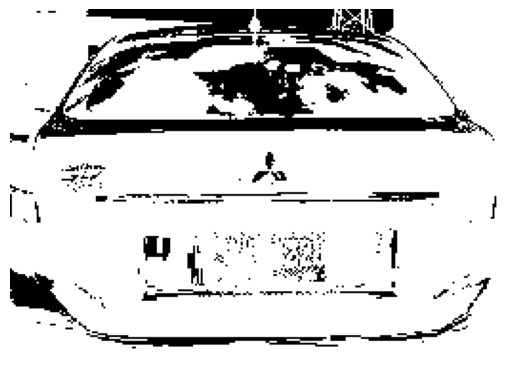

In [78]:
thresh = lpr.apply_threshold(gray)
plot_image(thresh)

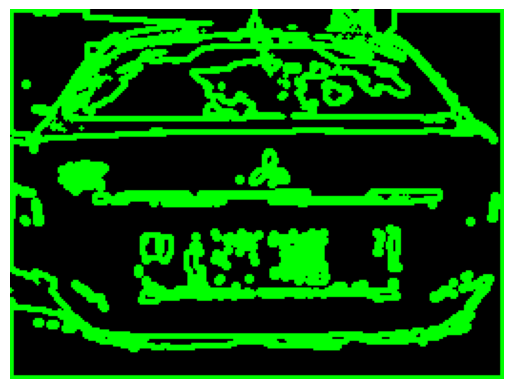

In [55]:
contours = lpr.find_contours(thresh)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

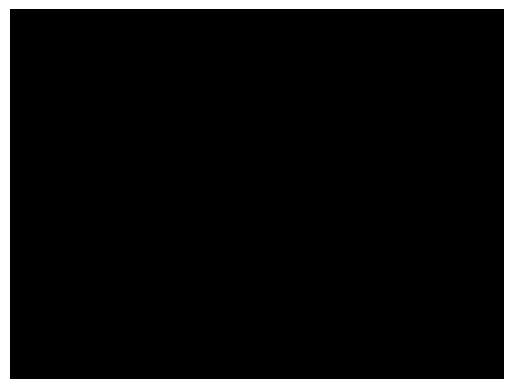

In [56]:
candidates = lpr.filter_candidates(contours)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , candidates, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

In [ ]:
license = lpr.get_lowest_candidate(candidates)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , [license], -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

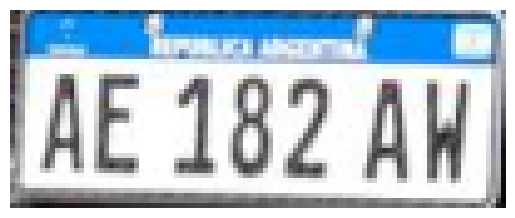

In [45]:
cropped = lpr.crop_license_plate(gray, license)
cropped2 = lpr.crop_license_plate(img, license)
plot_image(cropped2, False)

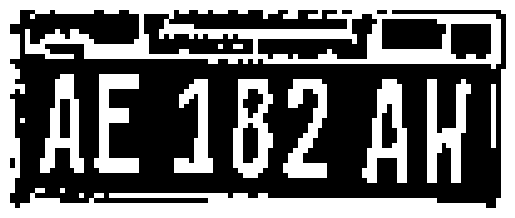

In [46]:
thresh_cropped = lpr.apply_adaptive_threshold(cropped)
plot_image(thresh_cropped)

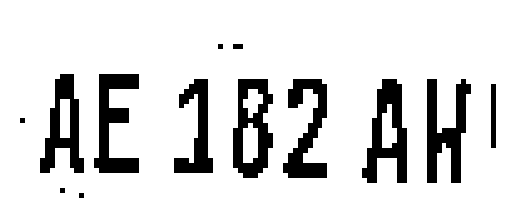

In [25]:
clear_border = lpr.clear_border(thresh_cropped)
final = lpr.invert_image(clear_border)
plot_image(final)

In [26]:
psm = 7
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
options += " --psm {}".format(psm)
txt = pytesseract.image_to_string(final, config=options)
print(txt[:2], txt[2:5], txt[5:])

AE 182 AX



In [ ]:
## PROCESAMIENTO Y CLASIFICACION DE IMAGENES DE MATRICULAS DE ARGENTINA - MODELO ORIGINAL

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from google.colab import drive
import skimage

# Montar Google Drive
drive.mount('/content/drive')

# Establecer la ruta del archivo ejecutable de Tesseract OCR en Google Colab
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

class LPR:
    def __init__(self, min_w=80, max_w=110, min_h=25, max_h=52, ratio=3.07692307692):
        self.min_w = min_w
        self.max_w = max_w
        self.min_h = min_h
        self.max_h = max_h
        self.ratio = ratio

    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def apply_threshold(self, img):
        return cv2.threshold(img, 170, 255, cv2.THRESH_BINARY_INV)[1]

    def apply_adaptive_threshold(self, img):
        return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 13)

    def find_contours(self, img):
        return cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

    def filter_candidates(self, contours):
        candidates = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h
            if (np.isclose(aspect_ratio, self.ratio, atol=0.7) and
               (self.max_w > w > self.min_w) and
               (self.max_h > h > self.min_h)):
                candidates.append(cnt)
        return candidates

    def get_lowest_candidate(self, candidates):
        ys = []
        for cnt in candidates:
            x, y, w, h = cv2.boundingRect(cnt)
            ys.append(y)
        return candidates[np.argmax(ys)]

    def crop_license_plate(self, img, license):
        x, y, w, h = cv2.boundingRect(license)
        return img[y:y+h, x:x+w]

    def clear_border(self, img):
        return skimage.segmentation.clear_border(img)

    def invert_image(self, img):
        return cv2.bitwise_not(img)

    def read_license(self, img, psm=7):
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = "-c tessedit_char_whitelist={}".format(alphanumeric)
        options += " --psm {}".format(psm)

        gray = self.grayscale(img)
        thresh = self.apply_threshold(gray)
        contours = self.find_contours(thresh)
        candidates = self.filter_candidates(contours)
        if candidates:
            license = candidates[0]
            if len(candidates) > 1:
                license = self.get_lowest_candidate(candidates)
            cropped = self.crop_license_plate(gray, license)
            thresh_cropped = self.apply_adaptive_threshold(cropped)
            clear_border = self.clear_border(thresh_cropped)
            final = self.invert_image(clear_border)
            txt = pytesseract.image_to_string(final, config=options)
            return txt
        else:
            return "No license plate found"

def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

lpr = LPR()

plates = ["AD440CY", "AB397UK", "AD233LT", "AE182AY", "AE182AW",
          "AE486WE", "AE796GG", "AD023DO", "AC883RA", "AC017TU",
          "AC017TN", "AD440CY", "AA854LC", "AE497FZ", "AC017TR",
          "AE622RT", "AD461GQ", "AA516IP", "AC724YO", "AE250FX",
          "AE521RQ", "AC883RJ", "AE676WN", "AE410HE", "AE444JH"]

for i in range(25):
    img_path = f"/content/drive/MyDrive/Colab Notebooks/Proyecto_Matrica_Automovil/imgs/{i:03}.png"
    print("Cargando imagen:", img_path)
    img = cv2.imread(img_path)

    if img is not None:
        txt = lpr.read_license(img)
        if txt[:-1] == plates[i]:
            print(f"{i:03} OK")
        else:
            print(f"{i:03} ERROR | Original: {plates[i]}", f"Recognized: {txt}")
    else:
        print(f"{i:03} ERROR | No se pudo cargar la imagen")


In [ ]:
## PROCESAMIENTO Y CLASIFICACION DE IMAGENES DE MATRICULAS DE PUERTO RICO

import numpy as np
import cv2
import pytesseract
import skimage
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')
# Establecer la ruta del archivo ejecutable de Tesseract OCR en Google Colab
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

class LPR:
    def __init__(self, min_w=80, max_w=110, min_h=25, max_h=52, ratio=3.07692307692):
        self.min_w = min_w
        self.max_w = max_w
        self.min_h = min_h
        self.max_h = max_h
        self.ratio = ratio

    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def apply_threshold(self, img):
        return cv2.threshold(img, 170, 255, cv2.THRESH_BINARY_INV)[1]

    def apply_adaptive_threshold(self, img):
        return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 13)

    def find_contours(self, img):
        return cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

    def filter_candidates(self, contours):
        candidates = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h
            if (np.isclose(aspect_ratio, self.ratio, atol=0.7) and
               (self.max_w > w > self.min_w) and
               (self.max_h > h > self.min_h)):
                candidates.append(cnt)
        return candidates

    def get_lowest_candidate(self, candidates):
        ys = []
        for cnt in candidates:
            x, y, w, h = cv2.boundingRect(cnt)
            ys.append(y)
        return candidates[np.argmax(ys)]

    def crop_license_plate(self, img, license):
        x, y, w, h = cv2.boundingRect(license)
        return img[y:y+h,x:x+w]

    def clear_border(self, img):
        return skimage.segmentation.clear_border(img)

    def invert_image(self, img):
        return cv2.bitwise_not(img)

    def read_license(self, img, psm=7):
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = "-c tessedit_char_whitelist={}".format(alphanumeric)
        options += " --psm {}".format(psm)

        gray = self.grayscale(img)
        thresh = self.apply_threshold(gray)
        contours = self.find_contours(thresh)
        candidates = self.filter_candidates(contours)
        if candidates:
            license = candidates[0]
            if len(candidates) > 1:
                license = self.get_lowest_candidate(candidates)
            cropped = self.crop_license_plate(gray, license)
            thresh_cropped = self.apply_adaptive_threshold(cropped)
            clear_border = self.clear_border(thresh_cropped)
            final = self.invert_image(clear_border)
            txt = pytesseract.image_to_string(final, config=options)
            return txt
        else:
            return "No license plate found"

def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

lpr = LPR()


plates = ["JXK228", "JBX459", "EBW258", "JWA554", "7UIM367"]


for i in range(5):
    img_path = f"/content/drive/MyDrive/Colab Notebooks/Proyecto_Matrica_Automovil/imgs-2/{i:03}.jpeg"
    print("Cargando imagen:", img_path)
    img = cv2.imread(img_path)

    if img is not None:
        txt = lpr.read_license(img)
        if txt[:-1] == plates[i]:
            print(f"{i:03} OK")
        else:
            print(f"{i:03} ERROR | Original: {plates[i]}", f"Recognized: {txt}")
    else:
        print(f"{i:03} ERROR | No se pudo cargar la imagen")
